In [1]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

In [ ]:
stops = pd.read_csv('DatosCsv/stops.txt')
comunas_data = pd.read_csv('comunas_proyeccion_poblacion_2024.csv')
comunas = gpd.read_file('comunas.geojson')

In [ ]:
geometry = [Point(xy) for xy in zip(stops['stop_lon'], stops['stop_lat'])]
stops_gdf = gpd.GeoDataFrame(stops, geometry=geometry, crs="EPSG:4326")

In [ ]:
stops_with_comuna = gpd.sjoin(stops_gdf, comunas, how="left", predicate="within")

In [ ]:
paradas_por_comuna = stops_with_comuna.groupby('name')['stop_id'].count().reset_index()
paradas_por_comuna.columns = ['Comuna', 'num_paradas']

In [ ]:
datos_comunas = comunas_data.merge(paradas_por_comuna, on='Comuna', how='left')
datos_comunas['num_paradas'] = datos_comunas['num_paradas'].fillna(0)

In [ ]:
datos_comunas['indice_cobertura'] = (datos_comunas['num_paradas'] / 
                                     np.sqrt(datos_comunas['Proyeccion_Personas_2024'] * 
                                             datos_comunas['Superficie_km2']))

In [ ]:
datos_comunas['indice_normalizado'] = (datos_comunas['indice_cobertura'] - datos_comunas['indice_cobertura'].min()) / (datos_comunas['indice_cobertura'].max() - datos_comunas['indice_cobertura'].min())

In [ ]:
comunas = comunas.merge(datos_comunas, left_on='name', right_on='Comuna')

In [ ]:
m = folium.Map(location=[-33.4569, -70.6483], zoom_start=10)

choropleth = folium.Choropleth(
    geo_data=comunas,
    name='Índice de Cobertura de Transporte',
    data=datos_comunas,
    columns=['Comuna', 'indice_normalizado'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Índice de Cobertura de Transporte'
).add_to(m)

In [ ]:
folium.GeoJson(
    comunas,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'num_paradas', 'Proyeccion_Personas_2024', 'Superficie_km2', 'indice_normalizado'],
        aliases=['Comuna:', 'Número de paradas:', 'Población:', 'Superficie (km²):', 'Índice de Cobertura:'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    ),
).add_to(m)

m.save('mapa_indice_cobertura_transporte.html')


        Comuna  num_paradas  Proyeccion_Personas_2024  Superficie_km2  \
0     Santiago          603                    544388            22.0   
1  Providencia          251                    164009            14.3   
2        Ñuñoa          369                    266906            16.9   
3   Las Condes          464                    343632            99.0   
4     Vitacura          183                     97049            28.3   

   indice_normalizado  
0            0.607754  
1            0.567749  
2            0.605821  
3            0.241557  
4            0.360947  


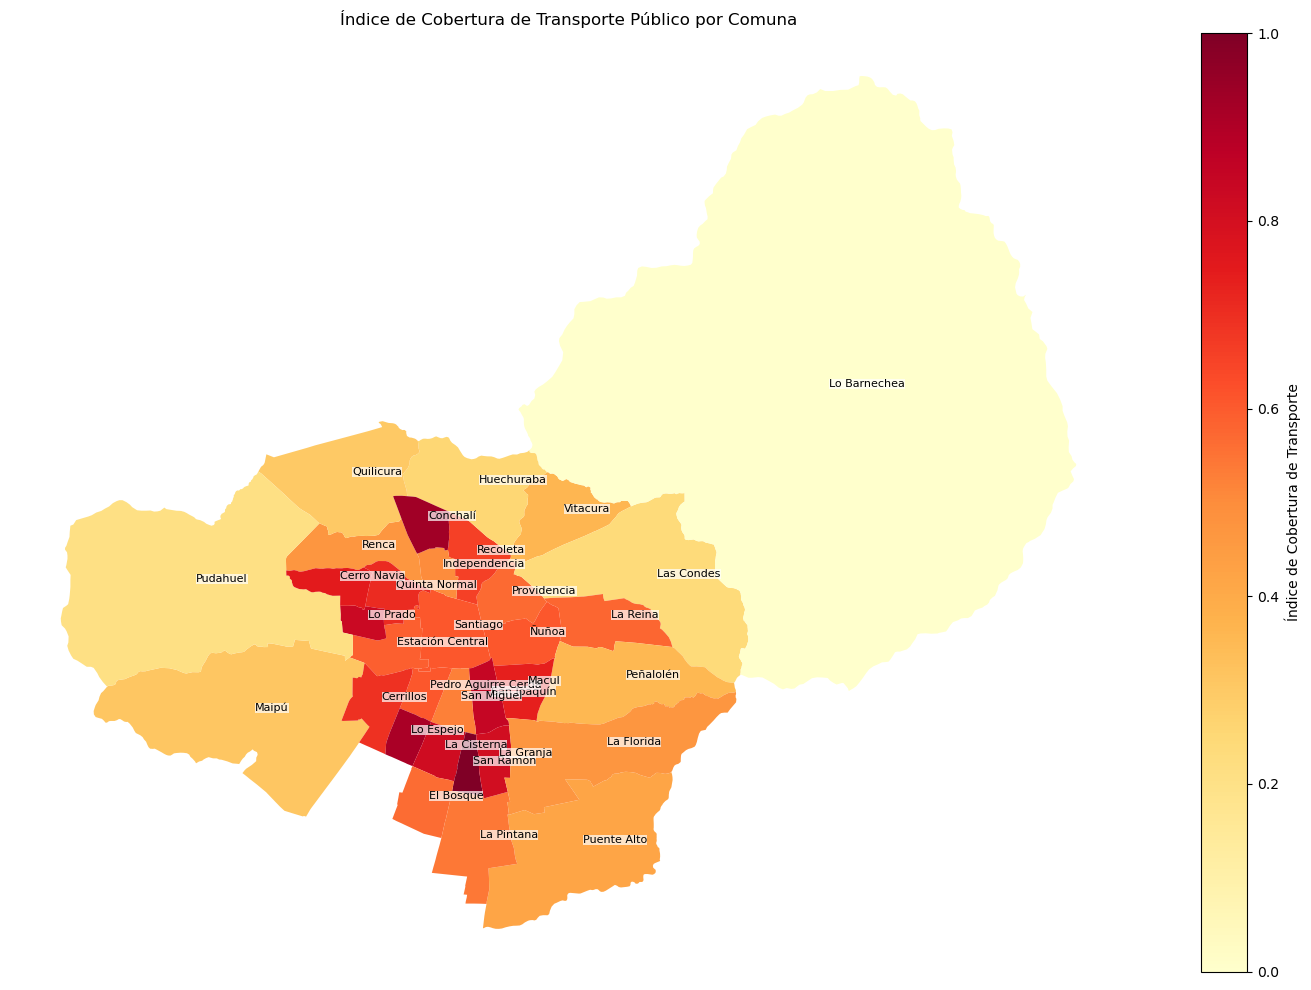

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
comunas.plot(column='indice_normalizado', 
             ax=ax, 
             legend=True, 
             legend_kwds={'label': 'Índice de Cobertura de Transporte'},
             cmap='YlOrRd')

for idx, row in comunas.iterrows():
    ax.annotate(text=row['name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords="offset points", fontsize=8, color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0))

ax.set_title('Índice de Cobertura de Transporte Público por Comuna')
plt.axis('off')
plt.tight_layout()
plt.savefig('mapa_estatico_indice_cobertura_transporte.png', dpi=300, bbox_inches='tight')

print(datos_comunas[['Comuna', 'num_paradas', 'Proyeccion_Personas_2024', 'Superficie_km2', 'indice_normalizado']].head())